# 세미3 프로젝트 

### Subject - Loan Prediction Based on Customer Behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 연속적 print, output clear
## source : display(target), clear_output(wait=True)
from IPython.display import clear_output

#Console Prograss Bar
from tqdm import tqdm, trange, tqdm_notebook

from sklearn import preprocessing, model_selection
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

import os
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline


#from imblearn.combine import SMOTETomek,SMOTEENN

## 01. Function
1.1 BI Chart Draw

In [95]:
def fn_countplot(p_df, p_x_column, p_rotation='0', p_figsize=(15,5) ):
    plt.figure(figsize=p_figsize)
    plt.xticks(rotation=p_rotation)
    sns.countplot(x=p_x_column, data=p_df)
    plt.show()
    
def fn_heatmap(p_df):
    plt.figure(figsize=(10, 10))
    sns.heatmap(p_df, cbar=True, square=True, fmt='.5f', annot=True, annot_kws={'size': 8}, cmap='YlGnBu')
    plt.plot()

def fn_pie(p_df):
    plt.pie(p_df, explode=[0.05, 0.1], labels=['Non-Defaulter', 'Defaulter'], radius=1.5, autopct='%1.1f%%',  shadow=True)
    plt.show()
    
def fn_auc(p_fpr, p_tpr):
    plt.style.use('fivethirtyeight') 
    fig, ax = plt.subplots() 
    fig.set_size_inches(4.8, 5) 
    ax.step(fpr, tpr, 'gray') 
    ax.fill_between(p_fpr, p_tpr, 0, color='skyblue', alpha=0.8) 
    ax.set_xlabel('False Positive Rate') 
    ax.set_ylabel('True Positive Rate') 
    ax.set_facecolor('xkcd:white') 
    plt.show()
    
#특성 중요도 수평 막대그래프
def fn_feature_horizontal_graph(p_model, p_np_data, p_df_x_train, p_numeric_features, p_cat_features):
    trans_features = []
    
    trans_features = p_numeric_features
    
    for f_col in p_cat_features:
        for i in range(p_df_x_train.groupby(f_col)[f_col].count().groupby(f_col).count().sum()):
            trans_features.append(f_col + '_' + str(i))
    
    plt.figure(figsize=(20,40))
    n_features = p_np_data.data.shape[1]
    plt.barh(range(n_features), p_model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),trans_features)
    plt.xlabel("Features Importances")
    plt.ylabel("Features")
    plt.ylim(-1,n_features)
    plt.show()

1.2 Label & Ordinal Encoder

In [3]:
def fn_encoder(p_df):
    
    df_return = p_df
    
    features_cat    = []
    
    for f_col in p_df:
        if p_df[f_col].dtype == 'object':
            
            cat_cnt = p_df.groupby(f_col)[f_col].count().groupby(f_col).count().sum()
            
            if cat_cnt < 10:
                print('#label# \t\t col_name :',f_col, '\t\t cnt : ', cat_cnt)
                ## 갯수가 적으면 label 인코더로..
                label_encoder    = preprocessing.LabelEncoder()
                df_return[f_col] = label_encoder.fit_transform(p_df[f_col])
            
            else:
                print('#Ordinal#\t\t col_name :',f_col, '\t\t cnt : ', cat_cnt)
                features_cat.append(f_col)
        
    
    ## ordinal_encoder 적용
    if(len(features_cat) > 0):
        ordinal_encoder = preprocessing.OrdinalEncoder()
        df_return.loc[:, features_cat] = ordinal_encoder.fit_transform(df_return.loc[:, features_cat])

    return df_return

## 02. 전처리 Proc

2.1 Data Load

In [4]:
df_loan_train = pd.read_csv("Training Data.csv")
df_loan_test = pd.read_csv("Test Data.csv")

del df_loan_train['Id']

df_loan_train['changed_profession'] = df_loan_train['Experience'] - df_loan_train['CURRENT_JOB_YRS']
df_loan_train['changed_profession'] = df_loan_train['changed_profession'].apply(lambda x:0 if (x == 0) else 1)

In [5]:
#income 소득
#Age    나이
#Experience 경험
#Married/Single 기혼/미혼
#House_Ownership 집_소유권
#Car_Ownership 차 소유권
#Prefession 직업
#City 도시
#state 상태
#current_job_yrs 현재 직업경력
#current_house_yrs 현재 집 소유 기간
#Risk_flag Target
display(df_loan_train.head(2))

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,changed_profession
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,1


In [6]:
display(df_loan_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
Income                252000 non-null int64
Age                   252000 non-null int64
Experience            252000 non-null int64
Married/Single        252000 non-null object
House_Ownership       252000 non-null object
Car_Ownership         252000 non-null object
Profession            252000 non-null object
CITY                  252000 non-null object
STATE                 252000 non-null object
CURRENT_JOB_YRS       252000 non-null int64
CURRENT_HOUSE_YRS     252000 non-null int64
Risk_Flag             252000 non-null int64
changed_profession    252000 non-null int64
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


None

2.1.1 Data Chart Draw

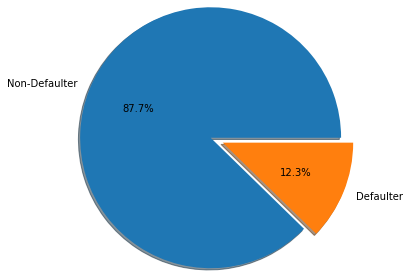

In [7]:
cnt_risk_flag = df_loan_train.groupby('Risk_Flag')['Risk_Flag'].count()
fn_pie(cnt_risk_flag)

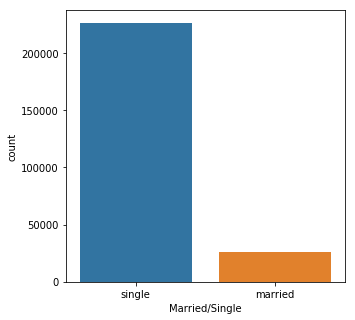

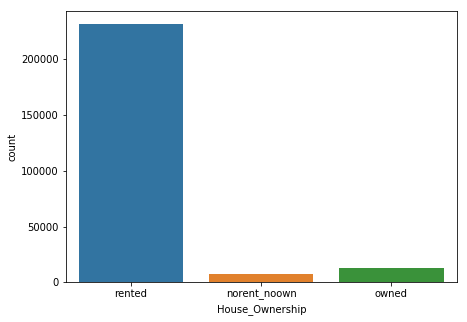

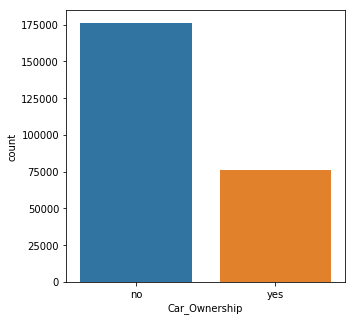

In [8]:
fn_countplot(df_loan_train, 'Married/Single', '0', (5,5))
fn_countplot(df_loan_train, 'House_Ownership', '0', (7,5))
fn_countplot(df_loan_train, 'Car_Ownership', '0', (5,5)) 

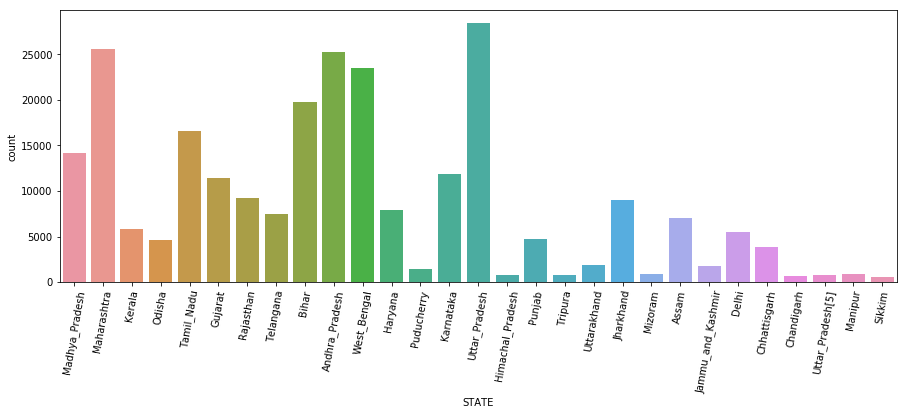

In [9]:
fn_countplot(df_loan_train, 'STATE', '80')

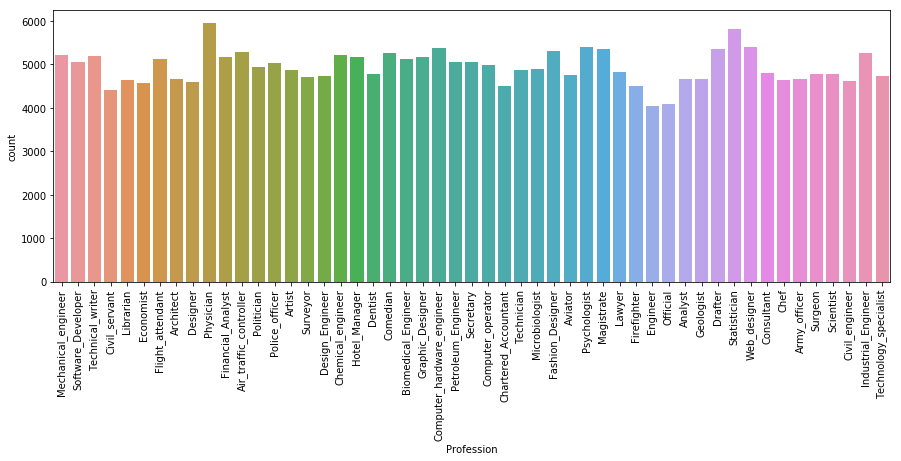

In [10]:
fn_countplot(df_loan_train, 'Profession', '90')

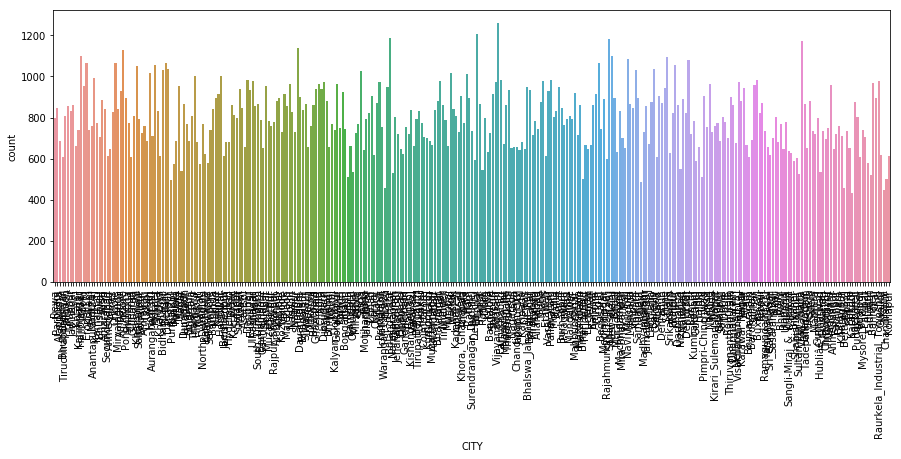

In [11]:
fn_countplot(df_loan_train, 'CITY', '90')

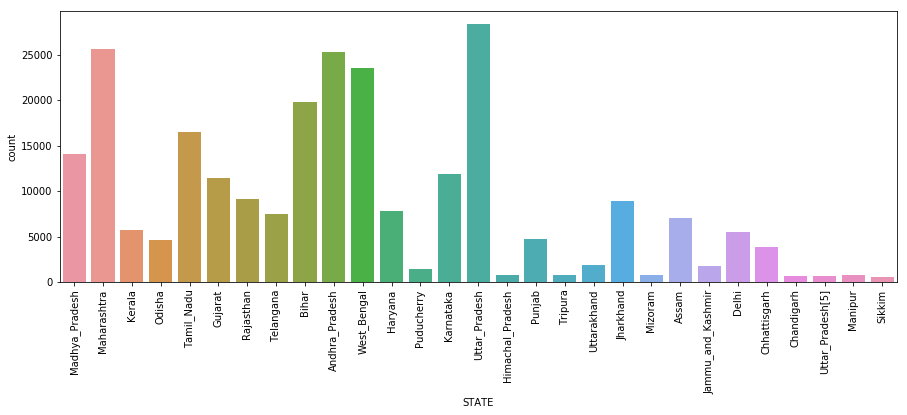

In [12]:
fn_countplot(df_loan_train, 'STATE', '90')

2.2 Processing

2.2.1 Proc Encoder|

In [13]:
del df_loan_train['CITY']

In [14]:
# Constructing a heatmap to understand the correlation
rtn_data = fn_encoder(df_loan_train)

#label# 		 col_name : Married/Single 		 cnt :  2
#label# 		 col_name : House_Ownership 		 cnt :  3
#label# 		 col_name : Car_Ownership 		 cnt :  2
#Ordinal#		 col_name : Profession 		 cnt :  51
#Ordinal#		 col_name : STATE 		 cnt :  29


In [15]:
rtn_data.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,changed_profession
0,1303834,23,3,1,2,0,33.0,13.0,3,13,0,0
1,7574516,40,10,1,2,0,43.0,14.0,9,13,0,1
2,3991815,66,4,0,2,0,47.0,12.0,4,10,0,0
3,6256451,41,2,1,2,1,43.0,17.0,2,12,1,0
4,5768871,47,11,1,2,0,11.0,22.0,3,14,1,1


In [18]:
rtn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
Income                252000 non-null int64
Age                   252000 non-null int64
Experience            252000 non-null int64
Married/Single        252000 non-null int32
House_Ownership       252000 non-null int32
Car_Ownership         252000 non-null int32
Profession            252000 non-null float64
STATE                 252000 non-null float64
CURRENT_JOB_YRS       252000 non-null int64
CURRENT_HOUSE_YRS     252000 non-null int64
Risk_Flag             252000 non-null int64
changed_profession    252000 non-null int64
dtypes: float64(2), int32(3), int64(7)
memory usage: 20.2 MB


2.2.2 Processing Data Chart Draw

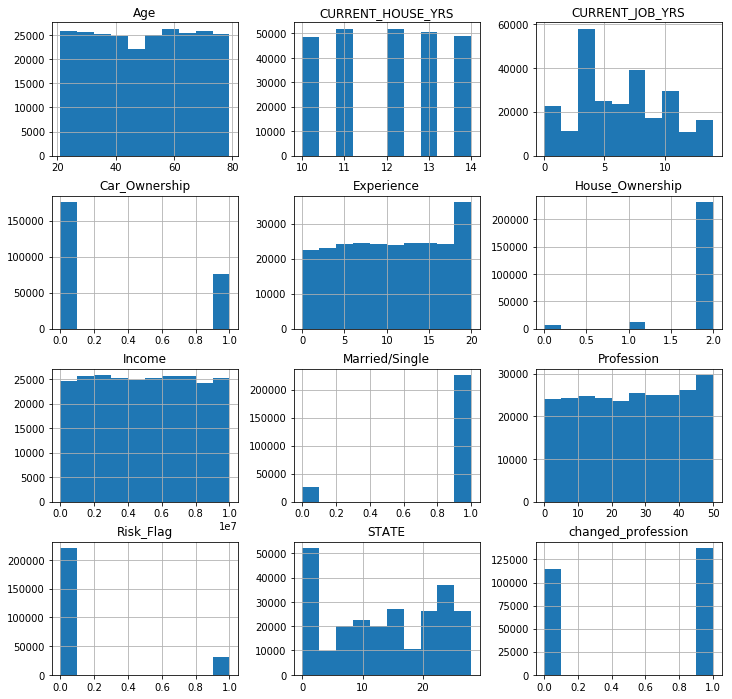

In [16]:
rtn_data.hist(figsize=(12, 12))
plt.show()

2.2.3 x data, y data 분리

In [17]:
x_data = rtn_data.drop('Risk_Flag', axis=1)
y_data = rtn_data['Risk_Flag']

In [19]:
for col in x_data:
    x_data[col] = x_data[col].astype(int)

2.2.4 Train - Test Split 처리 (0.2, Random = 0)

In [20]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=0)

2.2.5 Data(x_train, y_train) Under Sampling

No. of samples after under-Sampling: (74565, 11)
No. of samples after under-Sampling: (74565,)


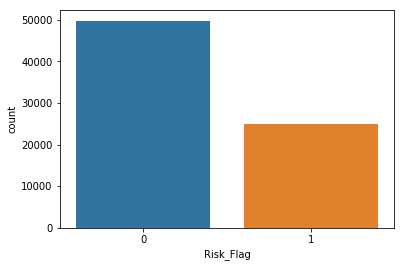

In [21]:
# Under Sampling
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
x_under,y_under = under_sampler.fit_resample(x_train,y_train)

print("No. of samples after under-Sampling:", x_under.shape)
print("No. of samples after under-Sampling:", y_under.shape)
sns.countplot(x = y_under)

2.2.6 Data(x_under, y_under) Over Sampling

No. of samples after Over-Sampling: (99420, 11)
No. of samples after Over-Sampling: (99420,)


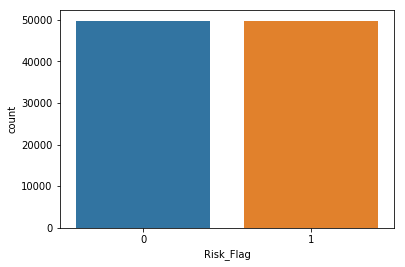

In [22]:
# Over Sampling
over_sampler = SMOTE(random_state=42, n_jobs=-1, sampling_strategy=1)
x_over,y_over = over_sampler.fit_resample(x_under,y_under)
print("No. of samples after Over-Sampling:",x_over.shape)
print("No. of samples after Over-Sampling:",y_over.shape)
sns.countplot(x = y_over)

In [23]:
display(x_over.shape)
display(y_over.shape)

(99420, 11)

(99420,)

2.2.7 Proc PipLIne(OneHotEncoder, StandardScaler)

In [77]:
x_over.groupby('Profession')['Profession'].count().groupby('Profession').count().sum()
x_over.groupby('STATE')['STATE'].count().groupby('STATE').count().sum()

29

In [25]:
x_over.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,changed_profession
0,3643187,77,20,1,2,0,50,11,12,14,1
1,6467283,65,13,1,2,1,2,13,11,12,1
2,2307941,32,18,1,0,0,17,28,13,10,1
3,7681002,25,4,1,2,0,14,14,4,13,0
4,3921208,43,20,1,2,1,23,2,11,12,1


In [63]:
# Pipline
numeric_features = ['Income','Age','Experience',
                    'CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']
numeric_transformer = preprocessing.StandardScaler()

categorical_features = ['Married/Single','House_Ownership',
                        'Car_Ownership','changed_profession',
                        'Profession','STATE']
categorical_transformer = preprocessing.OneHotEncoder(sparse=False)

preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

# x_train과 x_test 전처리 작업을 위한 fit (SC, One-Hot Encoder 적용 중)
preprocessor_pipe.fit(x_over)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Income', 'Age',
                                                   'Experience',
                                                   'CURRENT_JOB_YRS',
                                                   'CURRENT_HOUSE_YRS']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['Married/Single',
                                                   'House_Ownership',
                                                   'Car_Ownership',
                                                   'changed_profession',
                                                   'Profession', 'STATE'])]))])

In [64]:
x_train_transformed = preprocessor_pipe.transform(x_over)
x_test_transformed = preprocessor_pipe.transform(x_test)

x_train_tns = pd.DataFrame(x_train_transformed)
x_test_tns = pd.DataFrame(x_train_transformed)

In [65]:
x_train_tns.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,-0.461576,1.609132,1.708327,1.578942,1.463509,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.511193,0.904605,0.537845,1.305573,0.022052,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.921506,-1.032846,1.373904,1.852312,-1.419404,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.929263,-1.443820,-0.967059,-0.608015,0.742781,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.365811,-0.387029,1.708327,1.305573,0.022052,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
x_test_tns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99420 entries, 0 to 99419
Data columns (total 94 columns):
0     99420 non-null float64
1     99420 non-null float64
2     99420 non-null float64
3     99420 non-null float64
4     99420 non-null float64
5     99420 non-null float64
6     99420 non-null float64
7     99420 non-null float64
8     99420 non-null float64
9     99420 non-null float64
10    99420 non-null float64
11    99420 non-null float64
12    99420 non-null float64
13    99420 non-null float64
14    99420 non-null float64
15    99420 non-null float64
16    99420 non-null float64
17    99420 non-null float64
18    99420 non-null float64
19    99420 non-null float64
20    99420 non-null float64
21    99420 non-null float64
22    99420 non-null float64
23    99420 non-null float64
24    99420 non-null float64
25    99420 non-null float64
26    99420 non-null float64
27    99420 non-null float64
28    99420 non-null float64
29    99420 non-null float64
30    99420 non-null 

## 03. Traditional ML

In [79]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

3.1 ExtraTreesClassifier

In [80]:
x_train_transformed.shape

(99420, 94)

In [81]:
x_test_transformed.shape

(50400, 94)

In [82]:
xtree = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [88]:
xtree.fit(x_train_transformed, y_over)

ExtraTreesClassifier(n_jobs=-1, random_state=123)

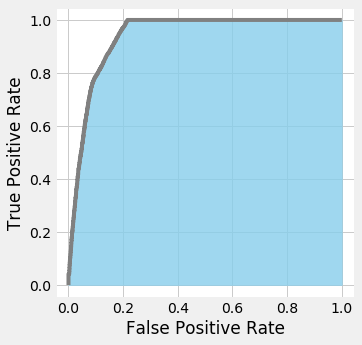

In [89]:
probas = xtree.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1])
fn_auc(fpr, tpr)

In [96]:
score = roc_auc_score(y_test, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', xtree.score(x_test_transformed, y_test))

AUC score 	: 0.9371534328107626
Model Score 	: 0.8638492063492064


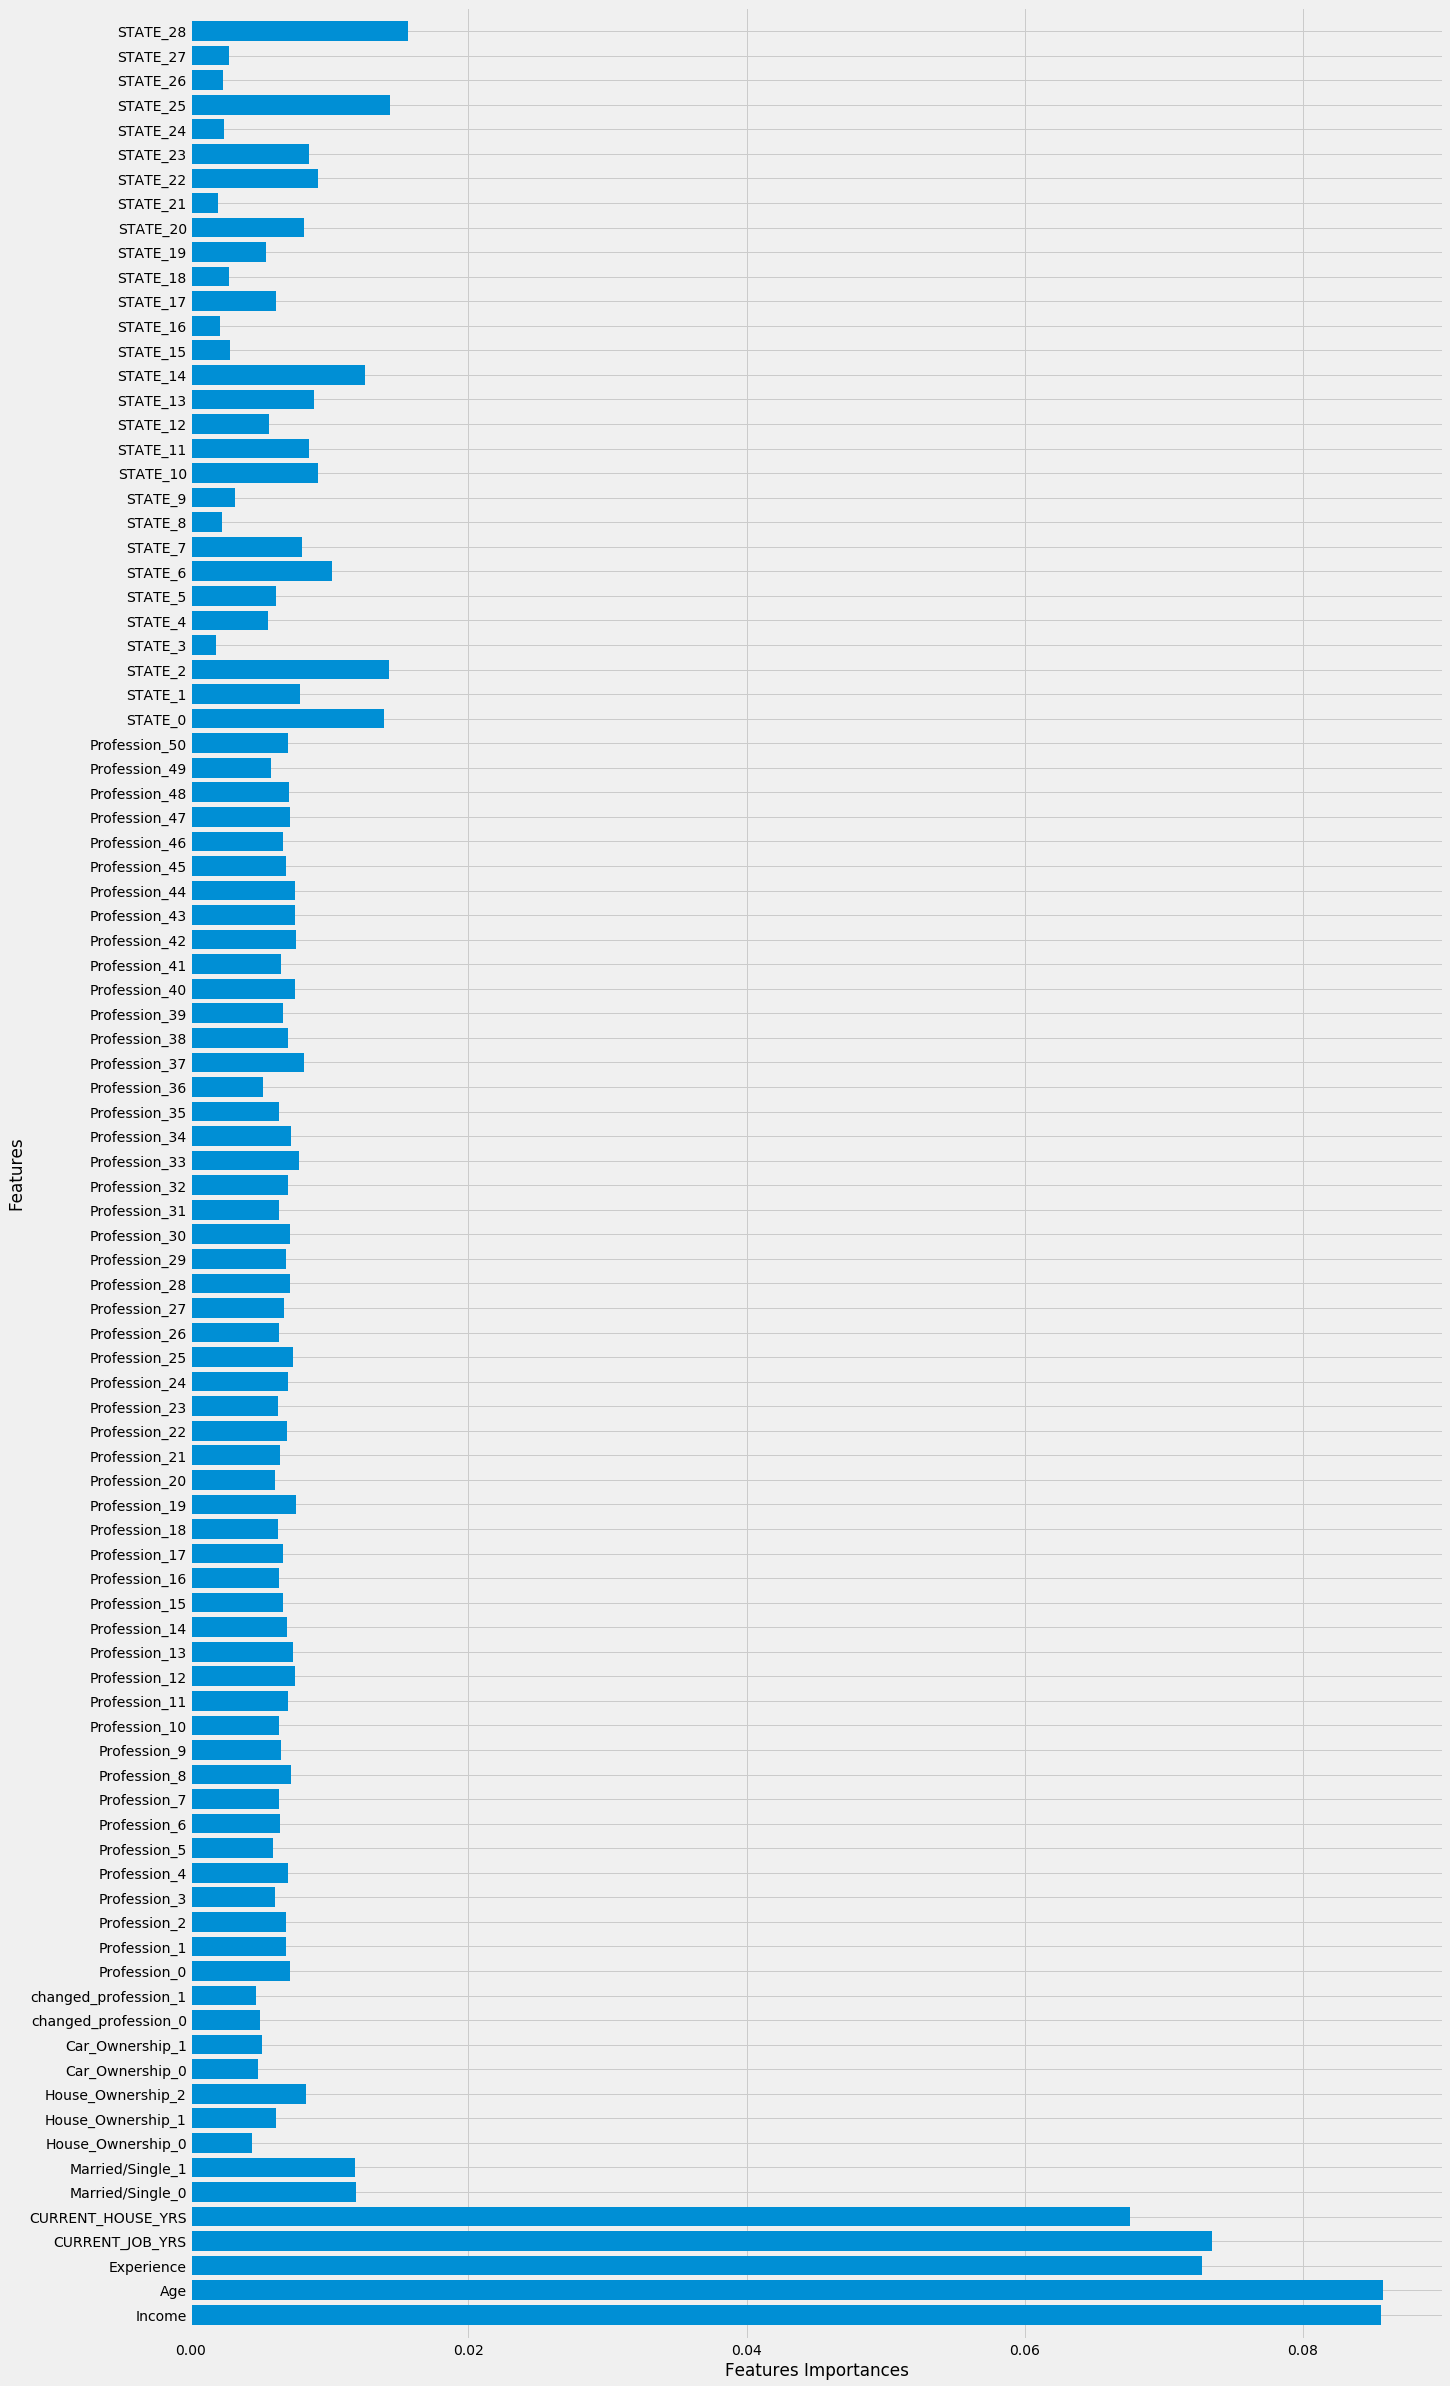

In [97]:
fn_feature_horizontal_graph(xtree, x_train_transformed, x_over, numeric_features, categorical_features)

3.2 DecisionTreeClassifier

In [49]:
dtree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=123, splitter='best')

In [50]:
dtree.fit(x_train_transformed, y_over)

DecisionTreeClassifier(random_state=123)

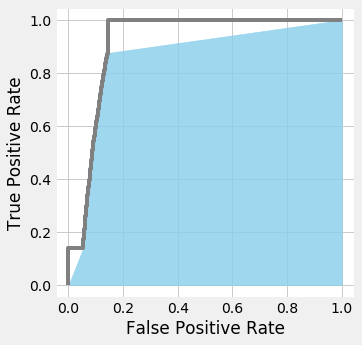

In [51]:
probas = dtree.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1])
fn_auc(fpr, tpr)

In [52]:
score = roc_auc_score(y_test, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', dtree.score(x_test_transformed, y_test))

AUC score 	: 0.8575963777989208
Model Score 	: 0.8588095238095238


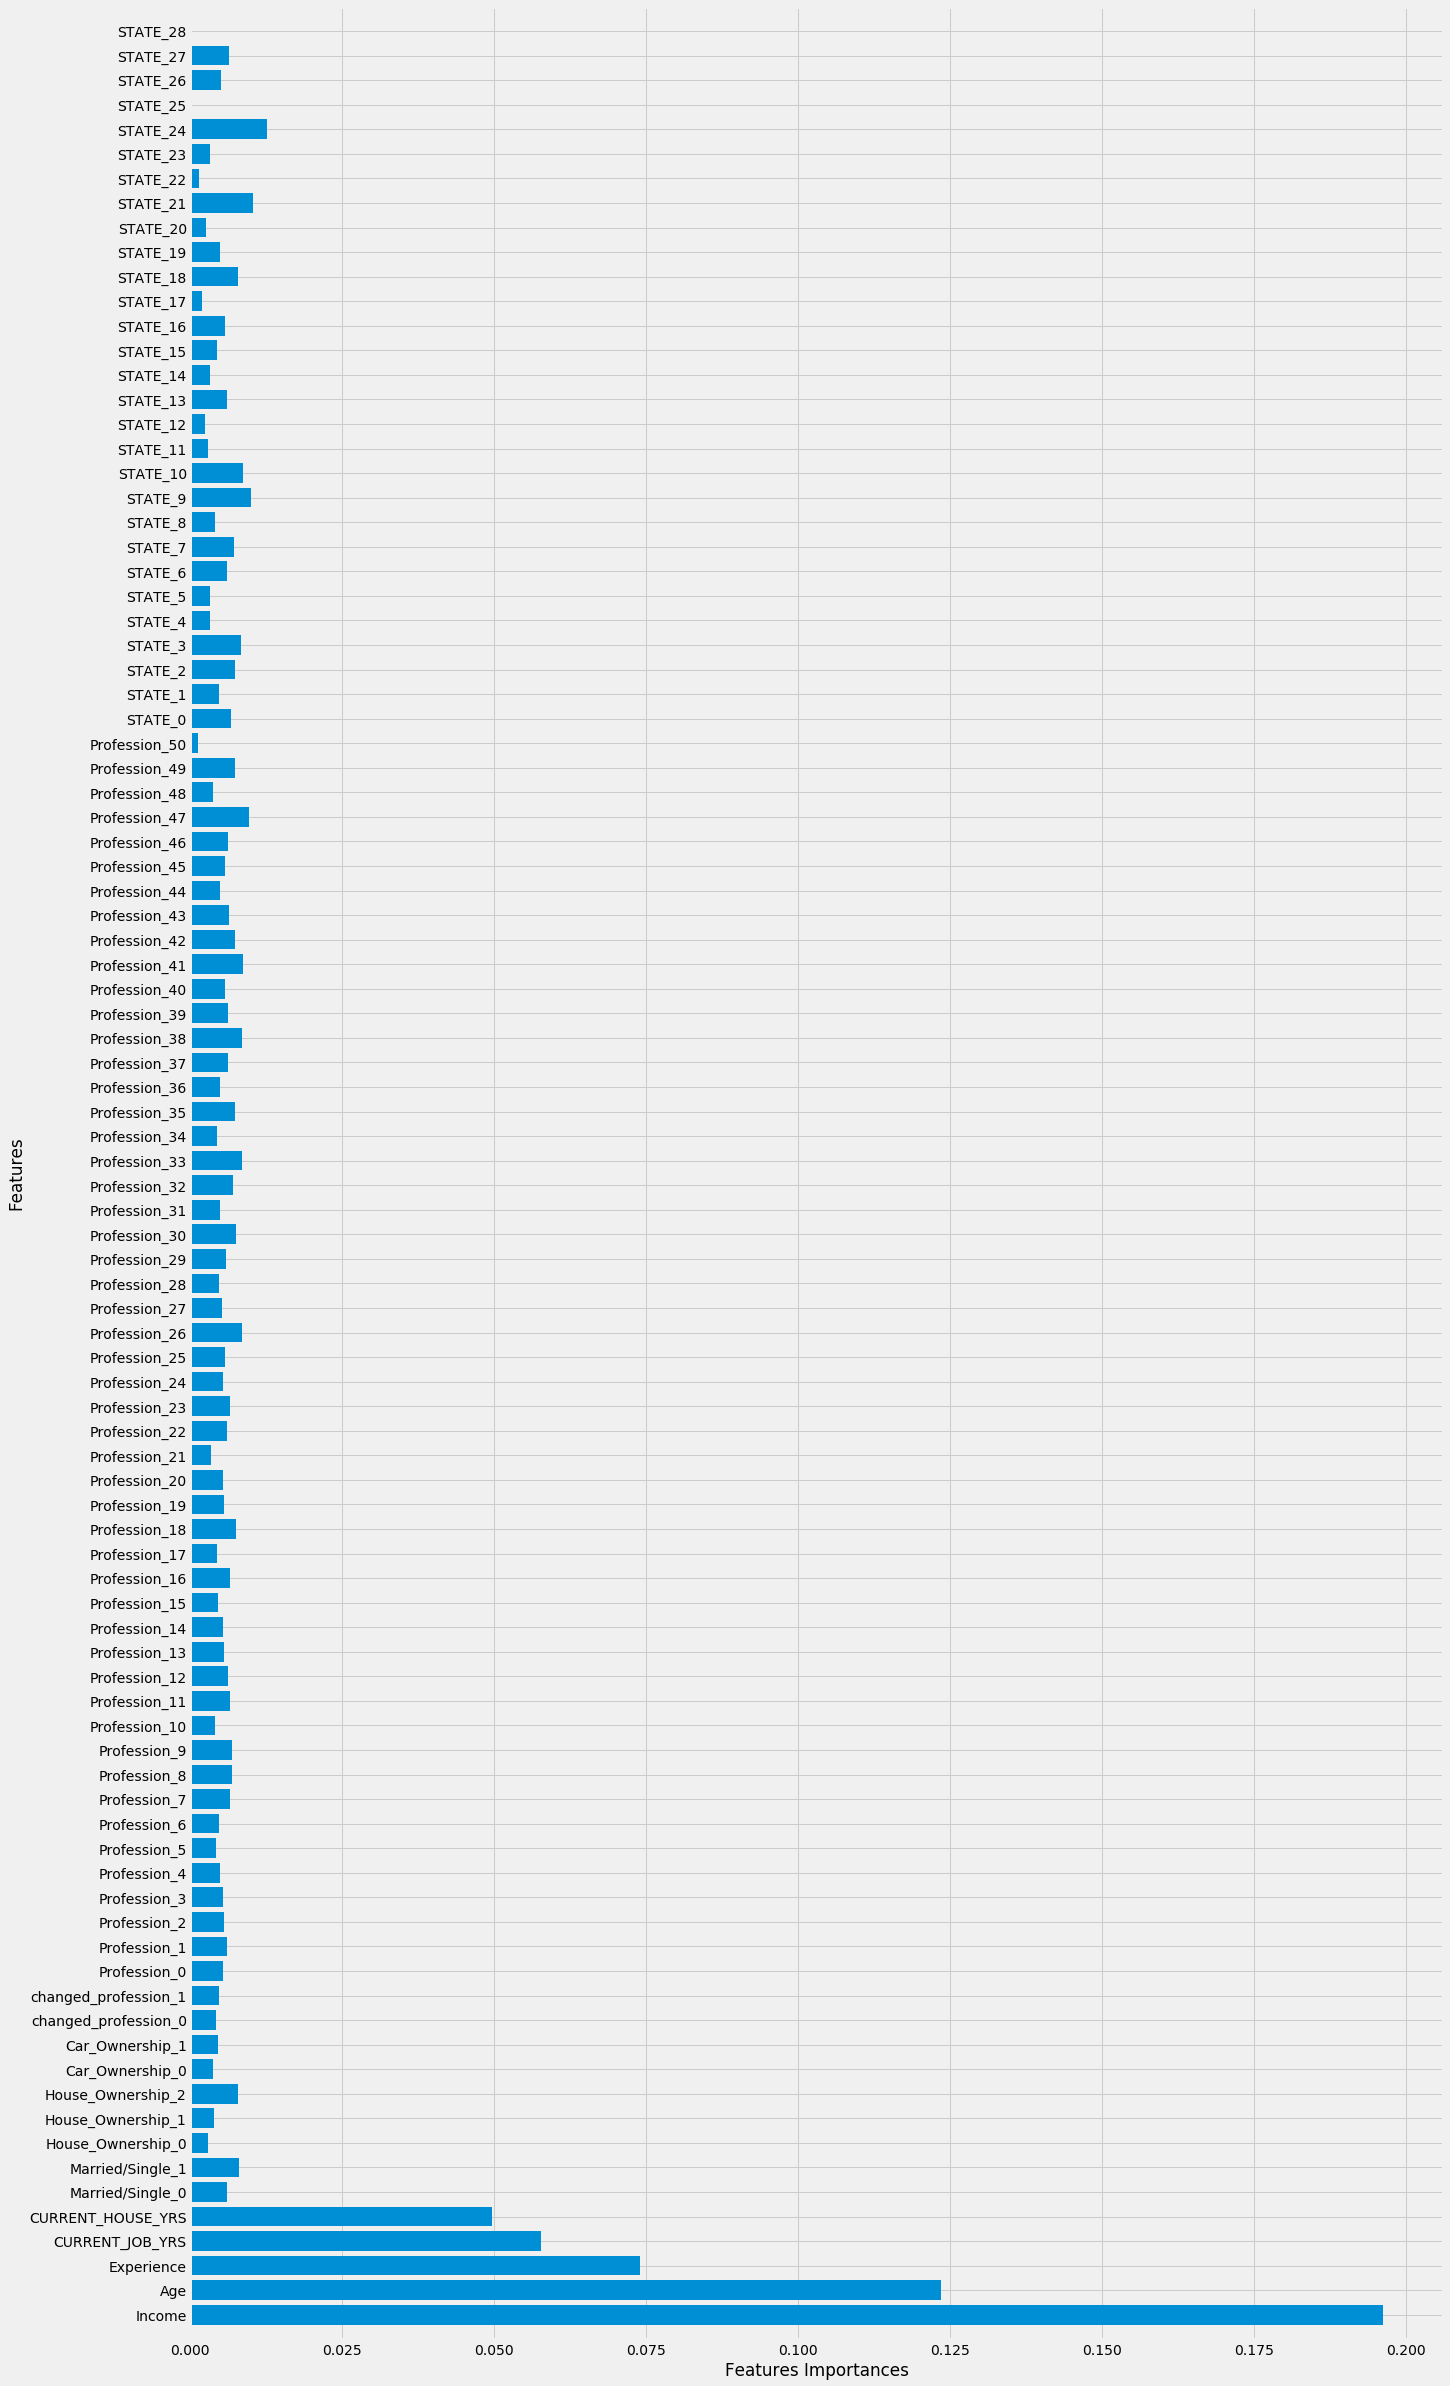

In [98]:
fn_feature_horizontal_graph(dtree, x_train_transformed, x_over, numeric_features, categorical_features)

3.3 RandomForestClassifier

In [54]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                        oob_score=False, random_state=123, verbose=0,
                        warm_start=False)

In [55]:
rf.fit(x_train_transformed, y_over)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=123)

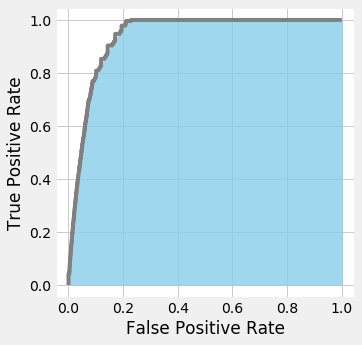

In [58]:
probas = rf.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1])
fn_auc(fpr, tpr)

In [59]:
score = roc_auc_score(y_test, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', rf.score(x_test_transformed, y_test))

AUC score 	: 0.9360281654539179
Model Score 	: 0.8745238095238095


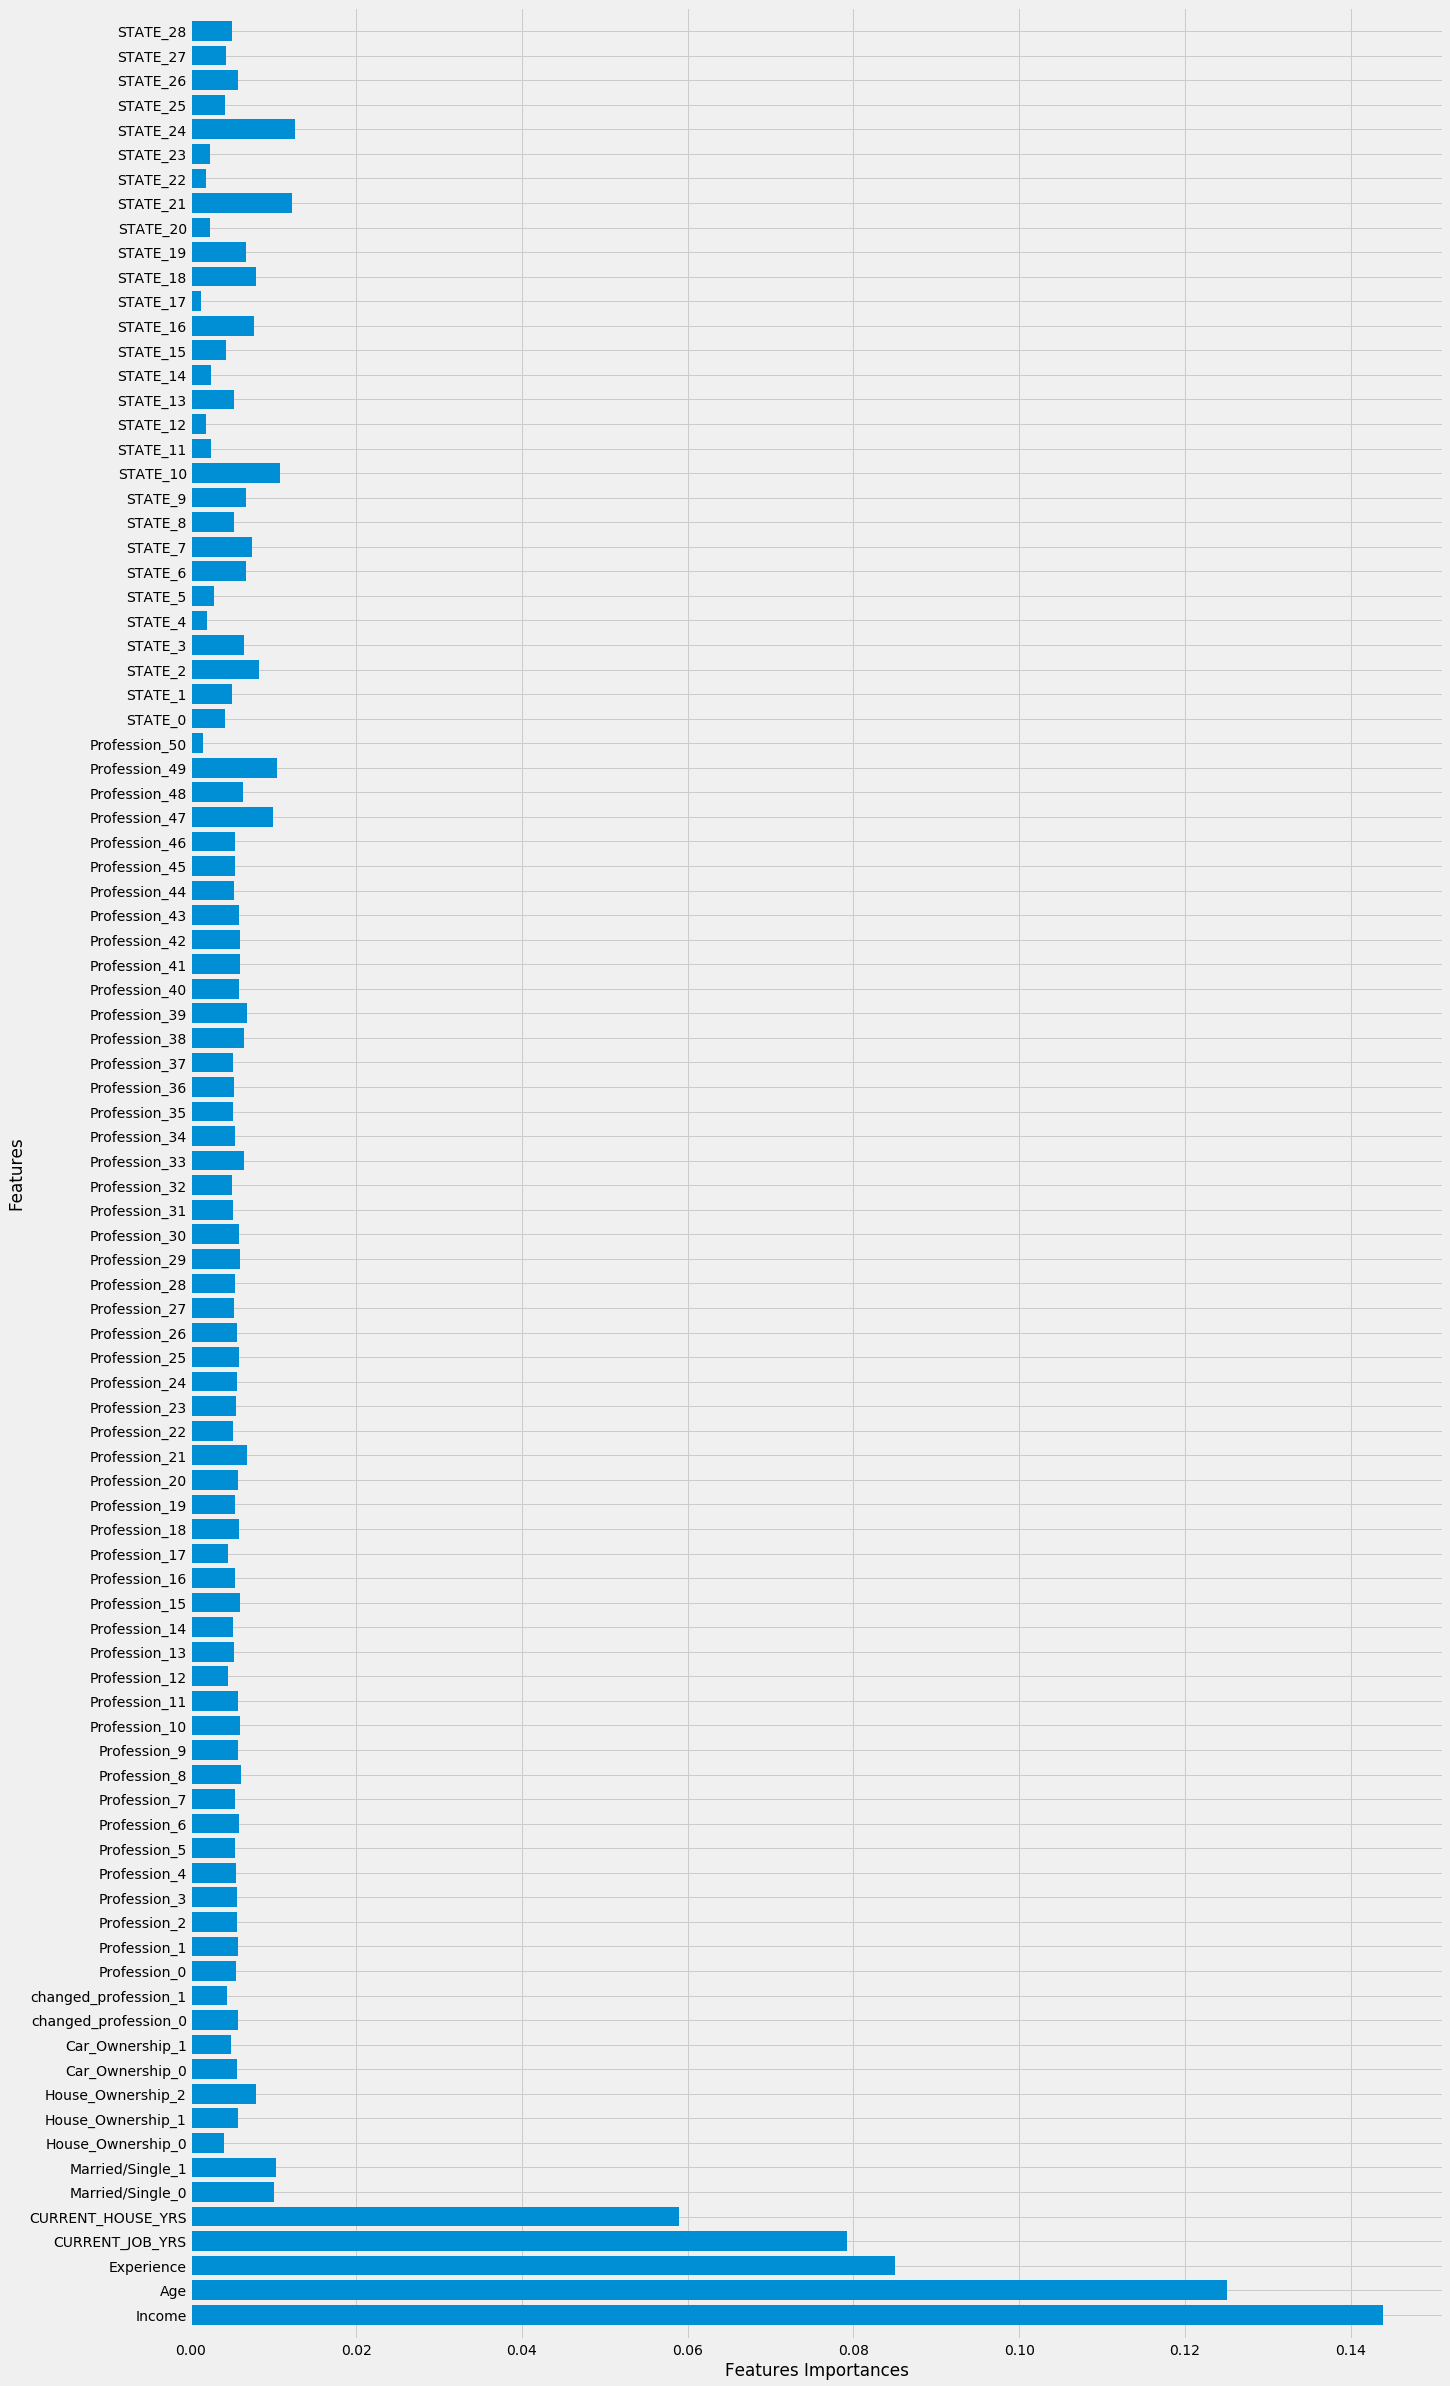

In [100]:
fn_feature_horizontal_graph(rf, x_train_transformed, x_over, numeric_features, categorical_features)